### Table of Contents:
* [1. Modeling Strategy and Initialization](#1)
* &emsp;[1.1. Importing Libraries](#11)
* &emsp;[1.2. Reading the Data & Splitting Traing and Test Datasets](#12)
* &emsp;[1.3. Defining Modeling Functions](#13)
* &emsp;[1.4. Defining K-Fold Cross Validation Splits](#14)
* [2. Modeling](#2)
* &emsp;[2.1. Classification Models](#21)
* &emsp;&emsp;[2.1.1. K-Nearest Neighbors Classifier](#211)
* &emsp;&emsp;&emsp;[2.1.1.1. Finding The Best Value of K](#2111)
* &emsp;&emsp;&emsp;[2.1.1.2. Confusion Matrix (Validation)](#2112)
* &emsp;&emsp;&emsp;[2.1.1.3. Confusion Matrix (Test)](#2113)
* &emsp;&emsp;[2.1.2. Random Forest Classifier](#212)
* &emsp;&emsp;&emsp;[2.1.2.1. Finding The Best Value of n_estimators](#2121)
* &emsp;&emsp;&emsp;[2.1.2.2. Confusion Matrix (Validation)](#2122)
* &emsp;&emsp;&emsp;[2.1.2.3. Confusion Matrix (Test)](#2123)
* &emsp;&emsp;[2.1.2. Ada-Boost Classifier](#213)
* &emsp;&emsp;&emsp;[2.1.2.1. Finding The Best Value of n_estimators](#2131)
* &emsp;&emsp;&emsp;[2.1.2.2. Confusion Matrix (Validation)](#2132)
* &emsp;&emsp;&emsp;[2.1.2.3. Confusion Matrix (Test)](#2133)
* &emsp;&emsp;[2.1.3. Gradient Boosting Classifier](#214)
* &emsp;&emsp;&emsp;[2.1.3.1. Finding The Best Value of n_estimators](#2141)
* &emsp;&emsp;&emsp;[2.1.3.2. Confusion Matrix (Validation)](#2142)
* &emsp;&emsp;&emsp;[2.1.3.3. Confusion Matrix (Test)](#2143)

# 1. Modeling Strategy and Initialization<a class="anchor" id="1"></a>

## 1.1. Importing Libraries<a class="anchor" id="11"></a>

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

## 1.2. Reading the Data & Splitting Traing and Test Datasets<a class="anchor" id="12"></a>

In [2]:
df = pd.read_csv('data/final_training_data.csv')

In [3]:
clf_target = 'isprofit' # classification model target
reg_target = 'profitability_ratio' # regression model target
des_features = ['budget', 'budget_norm', 'popularity', 'popularity_norm', 'runtime',
                'runtime_norm', 'score', 'score_norm', 'votes', 'votes_norm'] # descriptive features

In [4]:
X = df[des_features] # training data is the same for classification model and regression model
y1 = df[clf_target] # y1 corresponds to binary label outcome that will be used in classification
y2 = df[reg_target] # y2 corresponds to continuous outcome that will be used in regression

X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=17)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=17)

X_train = X_train.reset_index(drop=True)
y1_train = pd.DataFrame(y1_train).reset_index(drop=True)
y2_train = pd.DataFrame(y2_train).reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y1_test = pd.DataFrame(y1_test).reset_index(drop=True)
y2_test = pd.DataFrame(y2_test).reset_index(drop=True)

## 1.3. Defining Modeling Functions<a class="anchor" id="13"></a>

In [5]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            pass
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm

In [6]:
def run_kfold_model(X,y,X_test,y_test,model,fold_indexes,folds=[1,2,3],model_name='Unknown'):
    results = {}
    for fold in folds:
        print('='*5+' '+model_name+' - fold '+str(fold)+' '+'='*5)
        x_train = X.loc[list(fold_indexes[fold]['train'])]
        x_valid = X.loc[list(fold_indexes[fold]['valid'])]
        y_train = y.loc[list(fold_indexes[fold]['train'])]
        y_valid = y.loc[list(fold_indexes[fold]['valid'])]
        print('fitting model...')
        start_time = time.time()
        model.fit(x_train, np.ravel(y_train))
        ex_time = (time.time() - start_time)
        print('model fit!')
        results[fold] = {}
        results[fold]['model'] = model
        results[fold]['preds'] = {
            'train_y_pred': model.predict(x_train),
            'train_y_prob': model.predict_proba(x_train)[:,1],
            'valid_y_pred': model.predict(x_valid),
            'valid_y_prob': model.predict_proba(x_valid)[:,1],
            'test_y_pred': model.predict(X_test),
            'test_y_prob': model.predict_proba(X_test)[:,1]
        }
        results[fold]['execution_time'] = ex_time
        # pprint.pprint(results[fold])
    return results

## 1.4. Defining K-Fold Cross Validation Splits<a class="anchor" id="14"></a>

In [7]:
# This is where we create our folds
kf = KFold(n_splits=3, random_state=17, shuffle=True)
kf.get_n_splits(X_train)
fold_indexes = {}
i = 1
for train_index, valid_index in kf.split(X_train):
    fold_indexes[i]={}
    fold_indexes[i]['train']=train_index
    fold_indexes[i]['valid']=valid_index
    i+=1
    
y1_valid = np.ravel(y1_train.loc[list(fold_indexes[1]['valid'])+list(fold_indexes[2]['valid'])+list(fold_indexes[3]['valid'])])
y1_test = np.ravel(y1_test)

# 2. Modeling<a class="anchor" id="2"></a>

## 2.1. Classification Models<a class="anchor" id="21"></a>

### 2.1.1. K-Nearest Neighbor<a class="anchor" id="211"></a>

#### 2.1.1.1. Finding The Best Value of K<a class="anchor" id="2111"></a>

In [8]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y1_train.values.ravel())
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y1_test))

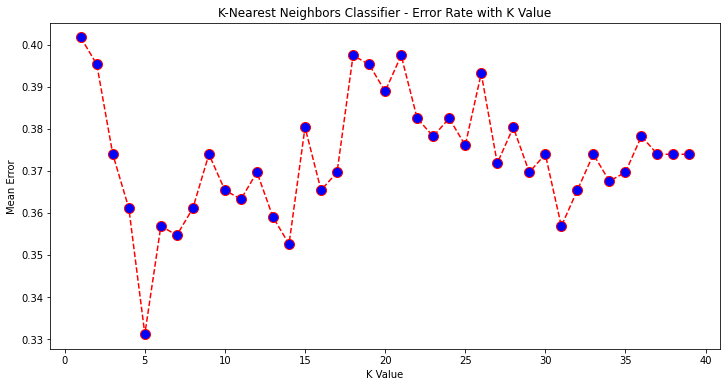

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('K-Nearest Neighbors Classifier - Error Rate with K Value');
plt.xlabel('K Value');
plt.ylabel('Mean Error');

The best suitable value of K is 5, as it has the lowest mean error.

#### 2.1.1.2. Confusion Matrix (Validation)<a class="anchor" id="2112"></a>

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
knn_results = run_kfold_model(X_train,y1_train,X_test,y1_test,knn,fold_indexes,model_name='KNN Classification')

===== KNN Classification - fold 1 =====
fitting model...
model fit!
===== KNN Classification - fold 2 =====
fitting model...
model fit!
===== KNN Classification - fold 3 =====
fitting model...
model fit!


In [11]:
valid_pred = list(knn_results[1]['preds']['valid_y_pred'])+\
             list(knn_results[2]['preds']['valid_y_pred'])+\
             list(knn_results[3]['preds']['valid_y_pred'])

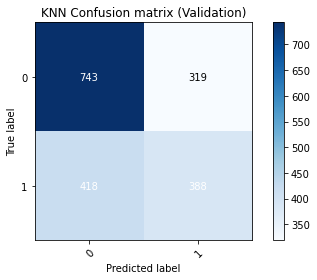

In [12]:
cm = plot_confusion_matrix(y1_valid,valid_pred,classes=[0,1],title='KNN Confusion matrix (Validation)')
plt.show()

In [13]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.605  (Overall, how often is the classifier correct?)
Sensitivity: 0.481  (When it's actually yes, how often does it predict yes?)
Specificity: 0.700  (When it's actually no, how often does it predict no?)
Precision  : 0.549  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.513  (Harmonic average of Sensitivity and Precision)


#### 2.1.1.3. Confusion Matrix (Test)<a class="anchor" id="2113"></a>

In [14]:
threshold = 0.5
test_probs = knn_results[1]['preds']['test_y_prob']+\
             knn_results[2]['preds']['test_y_prob']+\
             knn_results[3]['preds']['test_y_prob']
test_probs /= 3
test_pred = (test_probs>=threshold).astype(int)

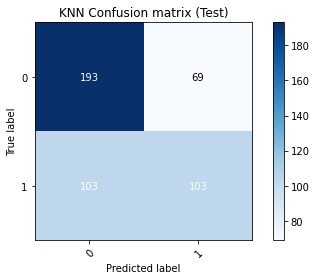

In [15]:
cm = plot_confusion_matrix(y1_test,test_pred,classes=[0,1],title='KNN Confusion matrix (Test)')
plt.show()

In [16]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.632  (Overall, how often is the classifier correct?)
Sensitivity: 0.500  (When it's actually yes, how often does it predict yes?)
Specificity: 0.737  (When it's actually no, how often does it predict no?)
Precision  : 0.599  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.545  (Harmonic average of Sensitivity and Precision)


### 2.1.2. Random Forest Classifier<a class="anchor" id="212"></a>

#### 2.1.2.1. Finding The Best Value of n_estimators<a class="anchor" id="2121"></a>

In [17]:
error = []
n_estimators = list(range(1,16))
for n_estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_estimator,min_samples_split=60, min_samples_leaf=20,
                                max_depth=7, random_state=17, max_features=None, verbose=0, max_leaf_nodes=14)
    rf.fit(X_train, y1_train.values.ravel())
    pred_i = rf.predict(X_test)
    error.append(np.mean(pred_i != y1_test))

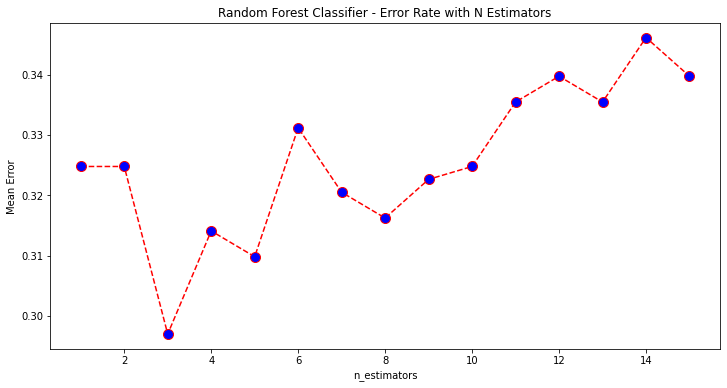

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Random Forest Classifier - Error Rate with N Estimators');
plt.xlabel('n_estimators');
plt.ylabel('Mean Error');

Minimum error rate at n_estimators = 3

#### 2.1.2.2. Confusion Matrix (Validation)<a class="anchor" id="2122"></a>

In [19]:
rf = RandomForestClassifier(n_estimators=3,min_samples_split=60, min_samples_leaf=20,
                                max_depth=7, random_state=17, max_features=None, verbose=0, max_leaf_nodes=14)
rf_results = run_kfold_model(X_train,y1_train,X_test,y1_test,rf,fold_indexes,model_name='RF Classification')

===== RF Classification - fold 1 =====
fitting model...
model fit!
===== RF Classification - fold 2 =====
fitting model...
model fit!
===== RF Classification - fold 3 =====
fitting model...
model fit!


In [20]:
valid_pred = list(rf_results[1]['preds']['valid_y_pred'])+\
             list(rf_results[2]['preds']['valid_y_pred'])+\
             list(rf_results[3]['preds']['valid_y_pred'])

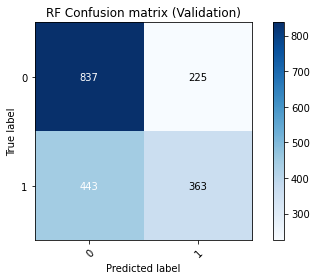

In [21]:
cm = plot_confusion_matrix(y1_valid,valid_pred,classes=[0,1],title='RF Confusion matrix (Validation)')
plt.show()

In [22]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.642  (Overall, how often is the classifier correct?)
Sensitivity: 0.450  (When it's actually yes, how often does it predict yes?)
Specificity: 0.788  (When it's actually no, how often does it predict no?)
Precision  : 0.617  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.521  (Harmonic average of Sensitivity and Precision)


#### 2.1.2.3. Confusion Matrix (Test)<a class="anchor" id="2123"></a>

In [23]:
threshold = 0.5
test_probs = rf_results[1]['preds']['test_y_prob']+\
             rf_results[2]['preds']['test_y_prob']+\
             rf_results[3]['preds']['test_y_prob']
test_probs /= 3
test_pred = (test_probs>=threshold).astype(int)

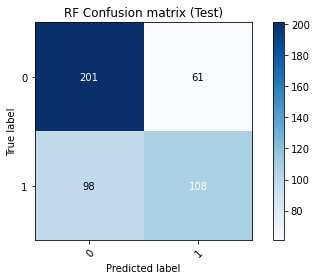

In [24]:
cm = plot_confusion_matrix(y1_test,pred_i,classes=[0,1],title='RF Confusion matrix (Test)')
plt.show()

In [25]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.660  (Overall, how often is the classifier correct?)
Sensitivity: 0.524  (When it's actually yes, how often does it predict yes?)
Specificity: 0.767  (When it's actually no, how often does it predict no?)
Precision  : 0.639  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.576  (Harmonic average of Sensitivity and Precision)


### 2.1.3. Ada-Boost Classifier<a class="anchor" id="213"></a>

#### 2.1.3.1. Finding The Best Value of n_estimators<a class="anchor" id="2131"></a>

In [26]:
error = []
n_estimators = list(range(1,25))
for n_estimator in n_estimators:
    adb = AdaBoostClassifier(n_estimators=n_estimator, random_state=0)
    adb.fit(X_train, y1_train.values.ravel())
    pred_i = adb.predict(X_test)
    error.append(np.mean(pred_i != y1_test))

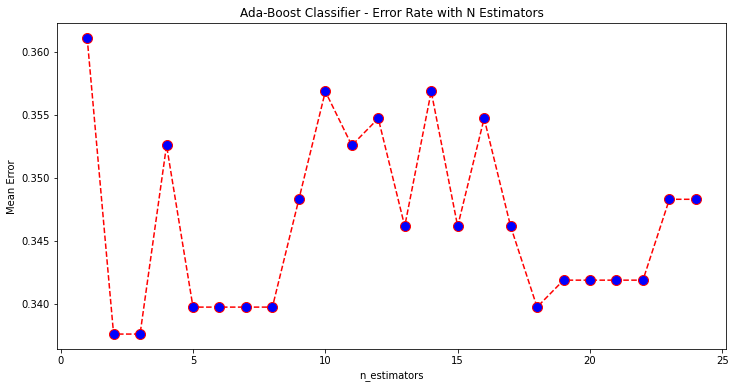

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Ada-Boost Classifier - Error Rate with N Estimators');
plt.xlabel('n_estimators');
plt.ylabel('Mean Error');

Minimum error rate at n_estimators = 4

#### 2.1.3.2. Confusion Matrix (Validation)<a class="anchor" id="2132"></a>

In [28]:
adb = AdaBoostClassifier(n_estimators=4, random_state=0)
adb_results = run_kfold_model(X_train,y1_train,X_test,y1_test,rf,fold_indexes,model_name='Adb Classification')

===== Adb Classification - fold 1 =====
fitting model...
model fit!
===== Adb Classification - fold 2 =====
fitting model...
model fit!
===== Adb Classification - fold 3 =====
fitting model...
model fit!


In [29]:
valid_pred = list(adb_results[1]['preds']['valid_y_pred'])+\
             list(adb_results[2]['preds']['valid_y_pred'])+\
             list(adb_results[3]['preds']['valid_y_pred'])

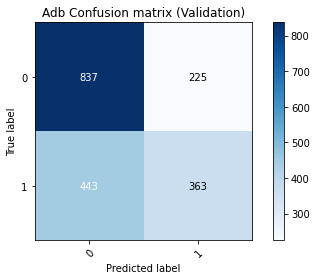

In [30]:
cm = plot_confusion_matrix(y1_valid,valid_pred,classes=[0,1],title='Adb Confusion matrix (Validation)')
plt.show()

In [31]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.642  (Overall, how often is the classifier correct?)
Sensitivity: 0.450  (When it's actually yes, how often does it predict yes?)
Specificity: 0.788  (When it's actually no, how often does it predict no?)
Precision  : 0.617  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.521  (Harmonic average of Sensitivity and Precision)


#### 2.1.3.3. Confusion Matrix (Test)<a class="anchor" id="2133"></a>

In [32]:
threshold = 0.5
test_probs = adb_results[1]['preds']['test_y_prob']+\
             adb_results[2]['preds']['test_y_prob']+\
             adb_results[3]['preds']['test_y_prob']
test_probs /= 3
test_pred = (test_probs>=threshold).astype(int)

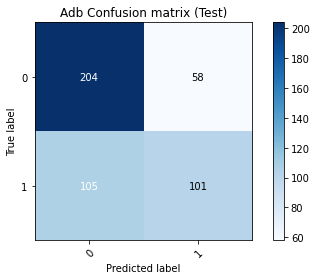

In [33]:
cm = plot_confusion_matrix(y1_test,pred_i,classes=[0,1],title='Adb Confusion matrix (Test)')
plt.show()

In [34]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.652  (Overall, how often is the classifier correct?)
Sensitivity: 0.490  (When it's actually yes, how often does it predict yes?)
Specificity: 0.779  (When it's actually no, how often does it predict no?)
Precision  : 0.635  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.553  (Harmonic average of Sensitivity and Precision)


### 2.1.4. Gradient Boosting Classifier<a class="anchor" id="214"></a>

#### 2.1.4.1. Finding The Best Value of n_estimators<a class="anchor" id="2141"></a>

In [39]:
error = []
n_estimators = [e*100 for e in list(range(15,25))]
for n_estimator in n_estimators:
    gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=n_estimator, criterion='friedman_mse', 
                                    min_samples_split=60, min_samples_leaf=20, max_depth=7, random_state=17,
                                    max_features=None, verbose=0, max_leaf_nodes=14, tol=0.0001)
    gb.fit(X_train, y1_train.values.ravel())
    pred_i = gb.predict(X_test)
    error.append(np.mean(pred_i != y1_test))

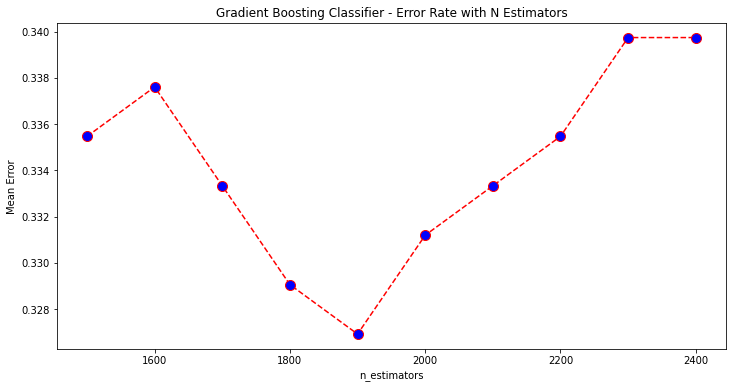

In [40]:
plt.figure(figsize=(12, 6))
plt.plot(n_estimators, error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Gradient Boosting Classifier - Error Rate with N Estimators');
plt.xlabel('n_estimators');
plt.ylabel('Mean Error');

The change in error rate is negligible after n_estimators >= 1900. Thus, we select n_estimators=1000

#### 2.1.4.2. Confusion Matrix (Validation)<a class="anchor" id="2142"></a>

In [41]:
gb = GradientBoostingClassifier(learning_rate=0.001, n_estimators=1900, criterion='friedman_mse', 
                                min_samples_split=60, min_samples_leaf=20, max_depth=7, random_state=17,
                                max_features=None, verbose=0, max_leaf_nodes=14, tol=0.0001)
gb_results = run_kfold_model(X_train,y1_train,X_test,y1_test,gb,fold_indexes,model_name='GB Classification')

===== GB Classification - fold 1 =====
fitting model...
model fit!
===== GB Classification - fold 2 =====
fitting model...
model fit!
===== GB Classification - fold 3 =====
fitting model...
model fit!


In [42]:
valid_pred = list(gb_results[1]['preds']['valid_y_pred'])+\
             list(gb_results[2]['preds']['valid_y_pred'])+\
             list(gb_results[3]['preds']['valid_y_pred'])

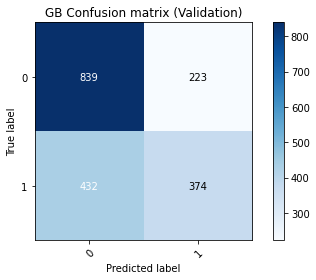

In [43]:
cm = plot_confusion_matrix(y1_valid,valid_pred,classes=[0,1],title='GB Confusion matrix (Validation)')
plt.show()

In [44]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.649  (Overall, how often is the classifier correct?)
Sensitivity: 0.464  (When it's actually yes, how often does it predict yes?)
Specificity: 0.790  (When it's actually no, how often does it predict no?)
Precision  : 0.626  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.533  (Harmonic average of Sensitivity and Precision)


#### 2.1.4.3. Confusion Matrix (Test)<a class="anchor" id="2143"></a>

In [45]:
threshold = 0.5
test_probs = gb_results[1]['preds']['test_y_prob']+\
             gb_results[2]['preds']['test_y_prob']+\
             gb_results[3]['preds']['test_y_prob']
test_probs /= 3
test_pred = (test_probs>=threshold).astype(int)

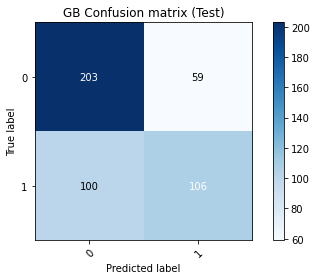

In [46]:
cm = plot_confusion_matrix(y1_test,pred_i,classes=[0,1],title='GB Confusion matrix (Test)')
plt.show()

In [47]:
TP, TN, FP, FN = cm[1,1], cm[0,0], cm[0,1], cm[1,0]
TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or true positive rate
TNR = TN/(TN+FP) # Specificity or true negative rate
PPV = TP/(TP+FP) # Precision or positive predictive value
F1S = 2*TPR*PPV/(TPR+PPV) # F-1 score
ACC = (TP+TN)/(TP+FP+FN+TN) # Overall accuracy
print('Accuracy   : %.3f' % ACC, " (Overall, how often is the classifier correct?)")
print('Sensitivity: %.3f' % TPR, " (When it's actually yes, how often does it predict yes?)")
print('Specificity: %.3f' % TNR, " (When it's actually no, how often does it predict no?)")
print('Precision  : %.3f' % PPV, " (When it predicts yes, how often is it correct??)")
print('F-1 Score  : %.3f' % F1S, " (Harmonic average of Sensitivity and Precision)")

Accuracy   : 0.660  (Overall, how often is the classifier correct?)
Sensitivity: 0.515  (When it's actually yes, how often does it predict yes?)
Specificity: 0.775  (When it's actually no, how often does it predict no?)
Precision  : 0.642  (When it predicts yes, how often is it correct??)
F-1 Score  : 0.571  (Harmonic average of Sensitivity and Precision)
